# Duplicate Image Prediction

Please visit the articile on my website for full write up. 
* https://www.jocampo.com/projects/2019/3/3/finding-duplicate-images-using-transfer-learning-on-deep-neural-networks

Concept: 
A discussion with a co-worker after a meeting generated this idea. He mentioned it would be nice if there was an easy way to identify duplicate images with a folder containing many image files. Seemed like a greate idea for a project. I think of this in 2 ways: 
1. Identifying similar/duplicate images 
2. The user interface to execute this application. 
I'm going to primarily focus on the former for now, and maybe circle back for the latter at some point. 

I'm re-using some of the code that I used for my previous project that explored deep learning on images using a transfer learning approach. Check that out if you haven't already. 
* https://www.jocampo.com/projects/2018/11/4/image-recognition-and-transfer-learning

### Sections 
* <a href='#Prep'>Prep</a>
* <a href='#Development'>Development</a>
* <a href='#Further Testing'>Further Testing</a>
* <a href='#Enhancements'>Enhancements</a>
* <a href='#Results'>Results</a>

<a name='Prep'></a>
# Prep
* Import the necessary packages
* Set working directory
* Set random seed to make reproducable

In [70]:
import pandas as pd
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras import backend as K
import os
import numpy as np
from numpy.random import seed
import json
from collections import Counter
from keras.optimizers import SGD
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import matplotlib.pyplot as plt
from IPython.display import Image as Image2
from IPython.display import display
from matplotlib.pyplot import imshow
import urllib
from tensorflow import set_random_seed
import tensorflow as tf
from scipy.spatial import distance_matrix

### Checking the GPU is running
Given the type of model I'll be using, I want to make sure the environment can take advantage of my computer's GPUs. 
If I've configured correctly, I should see a device_type called 'GPU'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11639883319221995804
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4934189393908121941
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Variable declaration

In [6]:
working_path = 'd:/projects/python/dupe_image_pred/'
os.chdir(working_path)

seed(1)
set_random_seed(2)

<a name='Development'></a>
# Development
* Load sample images
* Import pre-trained deep learning model
* Edit deep learning model
* Get model output for each image
* Check distances between them
* Show how duplicates would present


Get sample image to work. I'm using a naming convention that should make this easy to work with. The beginning is some name, like 'Goose' or 'NotGoose'. This is followed by an underscore and number. The number is simply a sequential number for the file, which creates a file ID. Later, I'll apply this method as an iterator for a larger number of images in a folder, as I did with the prior project. Lastly, for the development piece, I'm adding an underscore 1/0 to distinguish duplicates, where both duplicate images would have a 1. This makes it easy, as for the training set, I'm manually creating the duplicates. 

In [47]:
# change working directory
os.chdir(working_path+'/Images/Sample_Goose')

# get list of images (.jpg only)
sample_images = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]

# initialize
labels = []
dupe = []
idx_to_labels = []
label_to_idx = {}

# iterate
for fn in sample_images:
    if not fn in label_to_idx:
        label_to_idx[fn] = len(idx_to_labels)
        idx_to_labels.append(fn)
    labels.append(label_to_idx[fn])
    dupe.append(int(fn.replace('.jpg','').rsplit('_', 2)[2]))
len(idx_to_labels)

print('')
print('Number of images: ')
print(len(sample_images))
print('')
print('Sample images used: ')
print([i for i in idx_to_labels])
print('')


Number of images: 
3

Sample images used: 
['Goose_1_1.jpg', 'Goose_2_1.jpg', 'NotGoose_3_0.jpg']



Display images being used

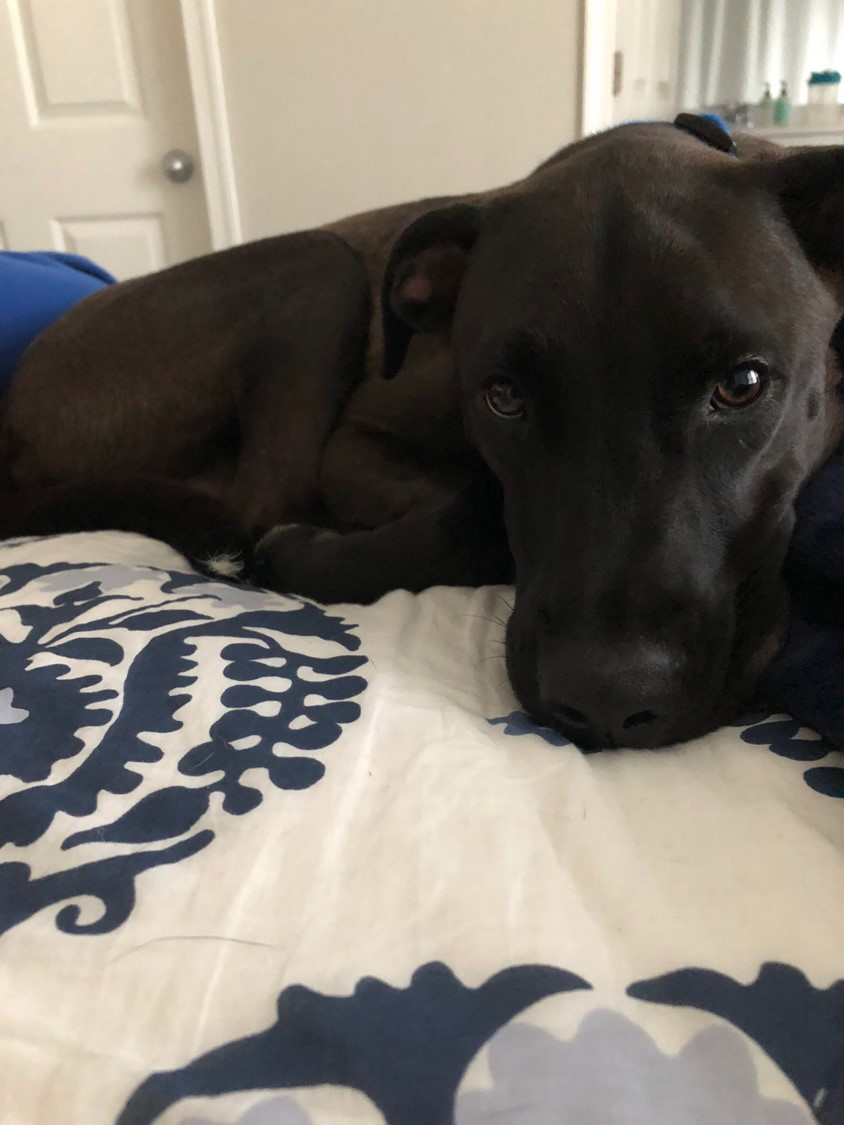

Goose_1_1.jpg


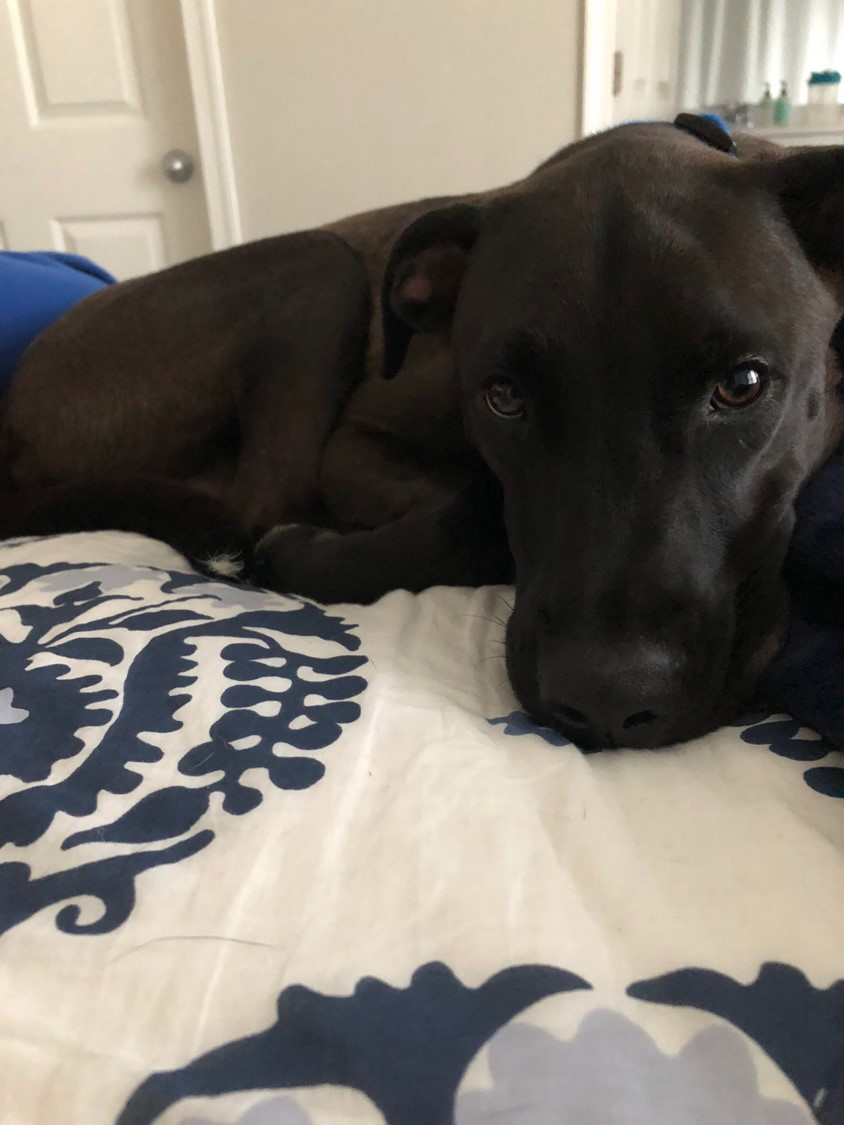

Goose_2_1.jpg


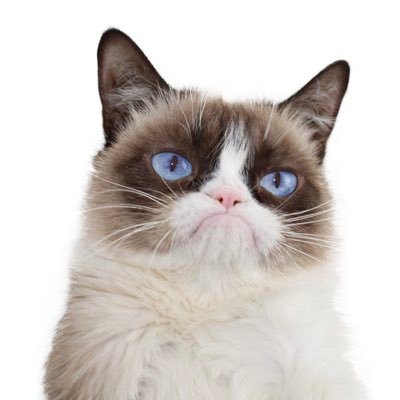

NotGoose_3_0.jpg


In [48]:
for pic in sample_images:
    display(Image2(pic, width = 150))
    print(pic)

As you can see, the first two images are duplicates of my dog, Goose. Grumpy cat is used for the last image, which is clearly not Goose. Here you can see the list of dupe tags derived from the file name: 

In [49]:
dupe

[1, 1, 0]

I now want to normalize my images into the same size and black & white coloring. 

This will iterate over my images, normalize them, and create a new image file in a new folder. 

In [50]:
for i in range(0,len(sample_images)): 
    os.chdir(working_path+'/Images/Sample_Goose')
    image_name = sample_images[i]
    temp_load = Image.open(image_name,'r')
    temp_load = temp_load.resize( (299,299), Image.ANTIALIAS )
    temp_load = temp_load.convert('L') # converts to monochrome
    temp_load = temp_load.convert('1') # converts to black and white
    os.chdir(working_path+'/Images/Sample_Goose/Norm')
    temp_load.save(image_name, temp_load.format)
    temp_load.close()
    
os.chdir(working_path+'/Images/Sample_Goose/Norm')
         
sample_images_rs = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]
         
org_img_count = len(sample_images)
rs_img_count = len(sample_images_rs)

print('\n Original Images: ' + str(org_img_count) + '\n Resized Images: ' + str(rs_img_count))


 Original Images: 3
 Resized Images: 3


Let's see the normalized images

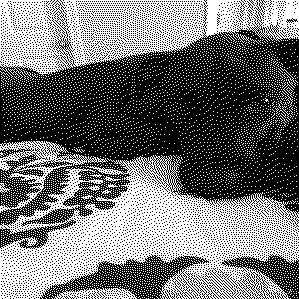

Goose_1_1.jpg


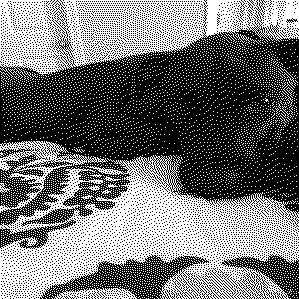

Goose_2_1.jpg


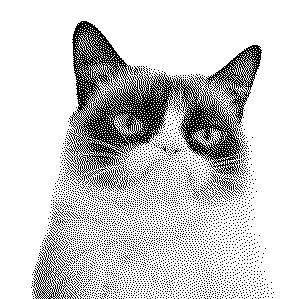

NotGoose_3_0.jpg


In [51]:
for pic in sample_images_rs:
    display(Image2(pic, width = 150))
    print(pic)

Check that the images have been resized

In [52]:
os.chdir(working_path+'/Images/Sample_Goose/Norm')

w_min = 1000
h_min = 1000
for i in range(1,len(sample_images_rs)):
    temp_img = Image.open(sample_images_rs[i])
    w, h = temp_img.size
    if w < w_min:
        w_min = w
    if h < h_min:
        h_min = h
    
print('\n Minimum image width: ' + str(w_min))
print('\n Minimum image height: ' + str(h_min) + '\n' )

for pic in sample_images_rs: 
    temp_img = Image.open(pic)
    print(pic + ' ' + str(temp_img.size))

print('\n')


 Minimum image width: 299

 Minimum image height: 299

Goose_1_1.jpg (299, 299)
Goose_2_1.jpg (299, 299)
NotGoose_3_0.jpg (299, 299)




Now, let's import pre-trained model that I'll use for feature engineering

In [42]:
# trainable = False is import because we'll be using this system for features but not output

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

Specify an additional layer that will be the output from the model

In [59]:
pool_2d = GlobalAveragePooling2D(name='pool_2d')(base_model.output)
dense = Dense(1024, name='dense', activation='relu')(pool_2d)
predictions = Dense(1000, activation='relu')(dense)
model = Model(inputs=base_model.input, outputs=predictions)

Load images

In [53]:
os.chdir(working_path+'/Images/Sample_Goose/Norm')

use_images = [image.load_img(c, target_size=(299,299))
         for c in sample_images]

use_tensor = np.array([image.img_to_array(img) for img in use_images])

With the pre-trained model that I edited before, capture the final layer for each image. 

In [62]:
model_output = model.predict(use_tensor, batch_size=32, verbose=1)

3/3 [==============================] - 2s 592ms/step


Check the shape of the output. For each image, there should be a row. The model's last layer that I added was 1000 nodes, so the resulting columns should be output of those 1000 nodes.

In [63]:
model_output.shape

(3, 1000)

With the results, put it into a dataframe and create a distance matrix from it. 

In [69]:
df = pd.DataFrame(model_output, index = sample_images)

In [71]:
dist_mat = pd.DataFrame(distance_matrix(df.values,df.values),index=df.index,columns=df.index)

See the resulting distance matrix to view the results.

In [72]:
dist_mat

Goose_1_1.jpg  Goose_2_1.jpg  NotGoose_3_0.jpg
Goose_1_1.jpg          0.000000       0.000000        222.033524
Goose_2_1.jpg          0.000000       0.000000        222.033524
NotGoose_3_0.jpg     222.033524     222.033524          0.000000

From this, we can see that NotGoose (aka Grumpy Cat) has a non-zero value, indicating it is not a duplicate. The two Goose files have a distance of zero, meaning they are duplicates. 

<a name='Further Testing'></a>
# Further Testing
* Run distance matrices for two more sets of images that are created to be slightly different for the other pictures in the set

For a different set of images of my other dog, Sadie, I'd like to see how to distances look for pictures that are slightly different from one another. 

Get list of files for Sadie

In [73]:
# change working directory
os.chdir(working_path+'/Images/Sample_Sadie')

# get list of images (.jpg only)
sadie_images = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]

# initialize
sadie_labels = []
sadie_dupe = []
sadie_idx_to_labels = []
sadie_label_to_idx = {}

# iterate
for fn in sadie_images:
    if not fn in sadie_label_to_idx:
        sadie_label_to_idx[fn] = len(sadie_idx_to_labels)
        sadie_idx_to_labels.append(fn)
    sadie_labels.append(sadie_label_to_idx[fn])
    sadie_dupe.append(int(fn.replace('.jpg','').rsplit('_', 2)[2]))
len(sadie_idx_to_labels)

print('')
print('Number of images: ')
print(len(sadie_images))
print('')
print('Sample images used: ')
print([i for i in sadie_idx_to_labels])
print('')


Number of images: 
6

Sample images used: 
['Sadie_1_0.jpg', 'Sadie_2_0.jpg', 'Sadie_3_0.jpg', 'Sadie_4_0.jpg', 'Sadie_5_0.jpg', 'Sadie_6_0.jpg']



See the pictures of Sadie.

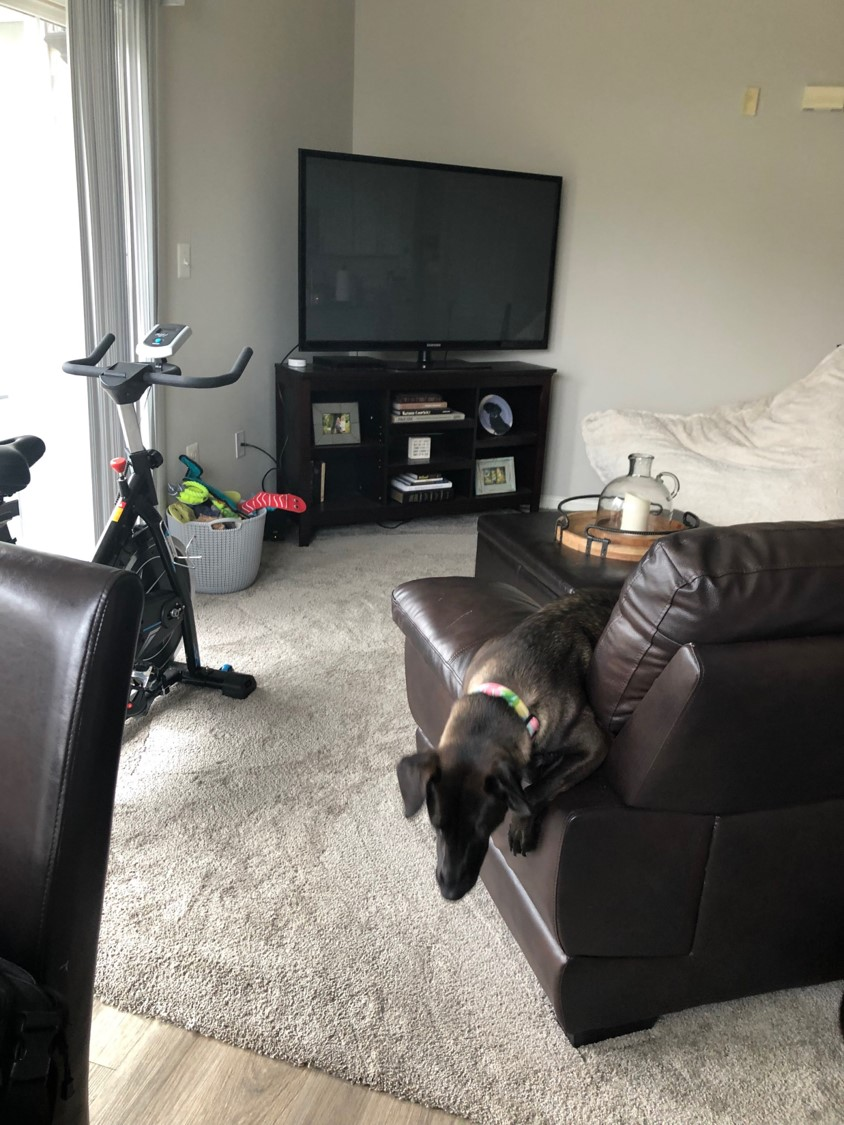

Sadie_1_0.jpg


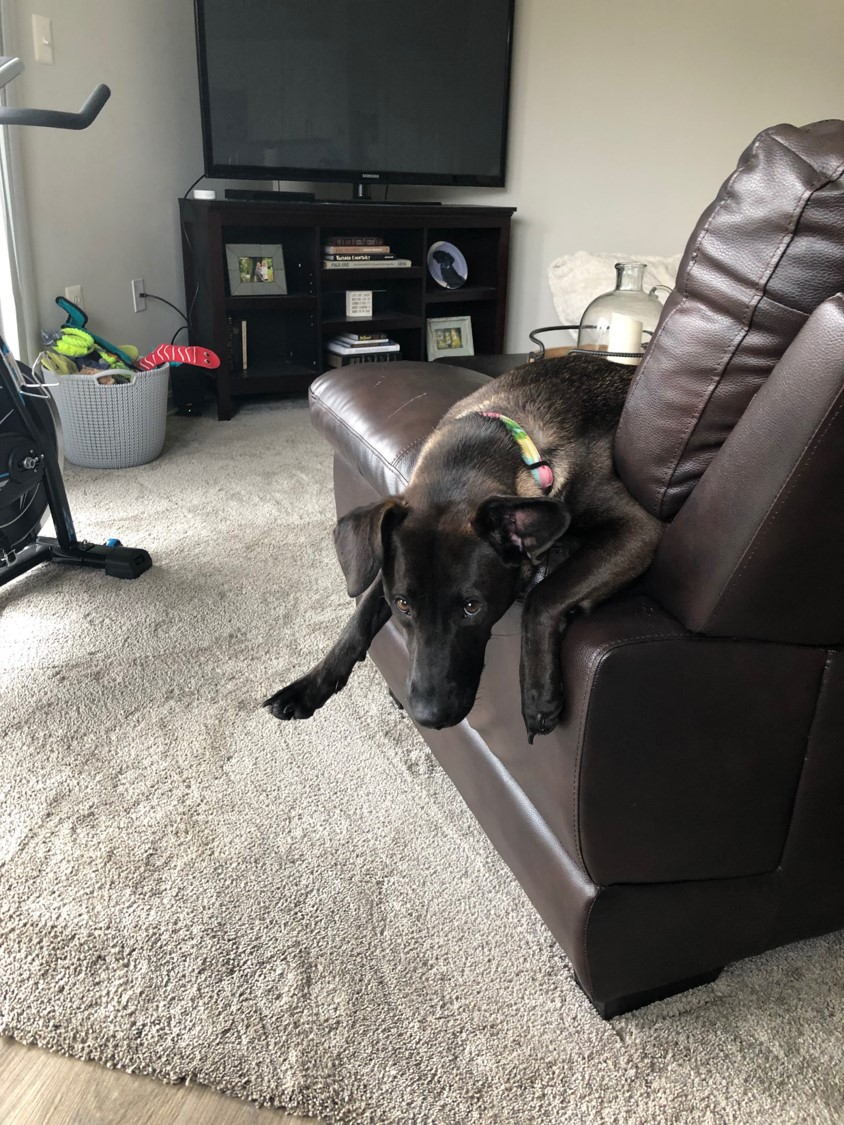

Sadie_2_0.jpg


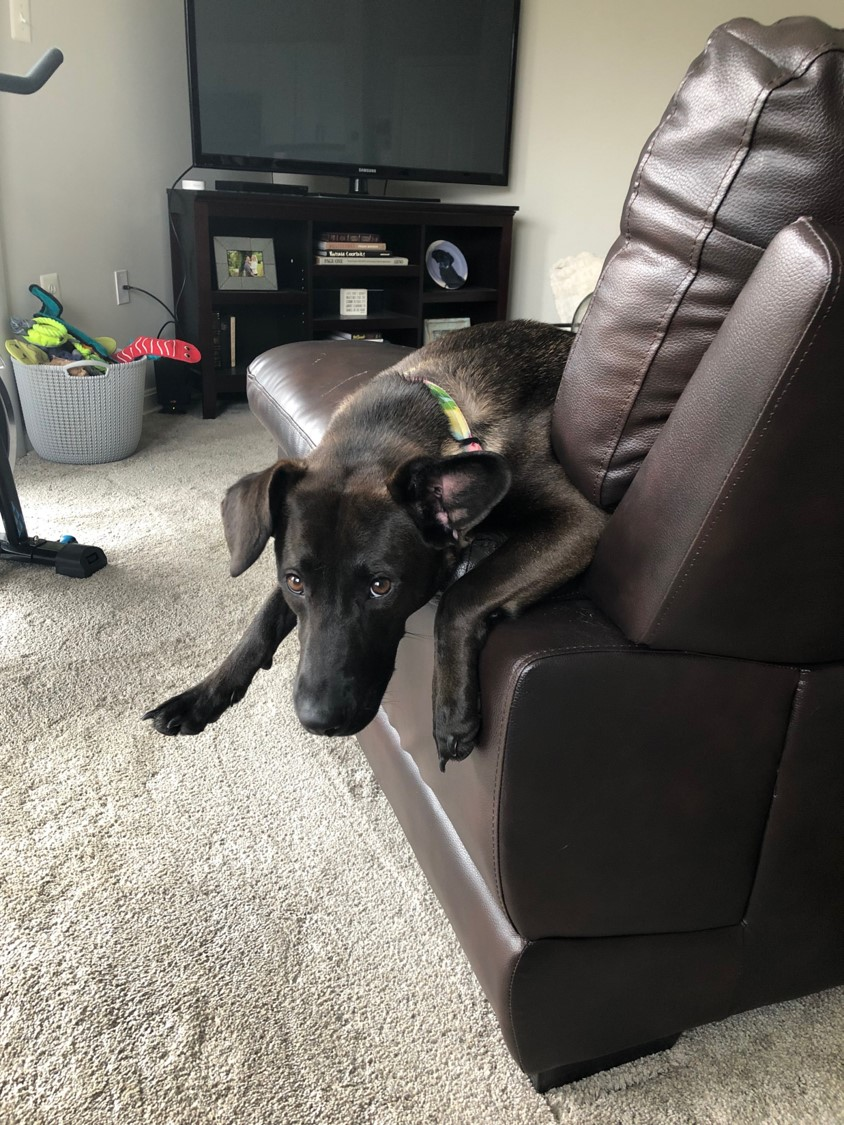

Sadie_3_0.jpg


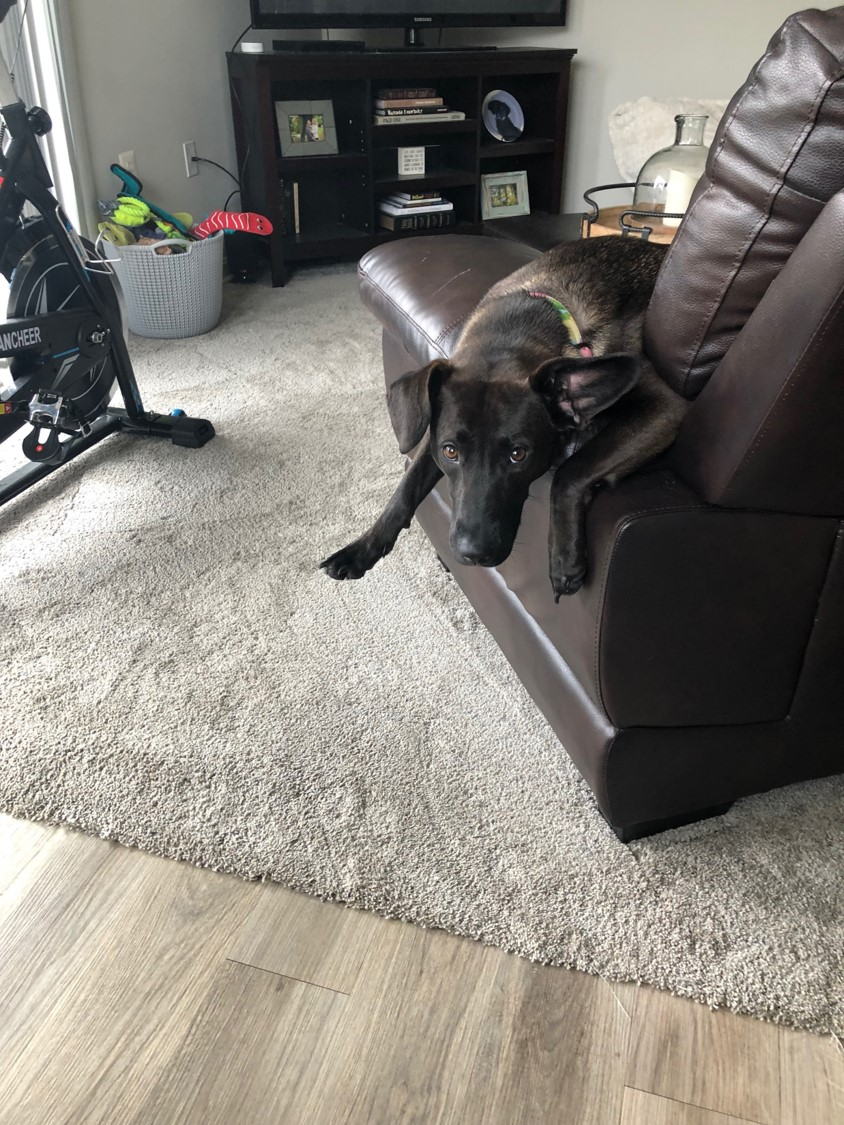

Sadie_4_0.jpg


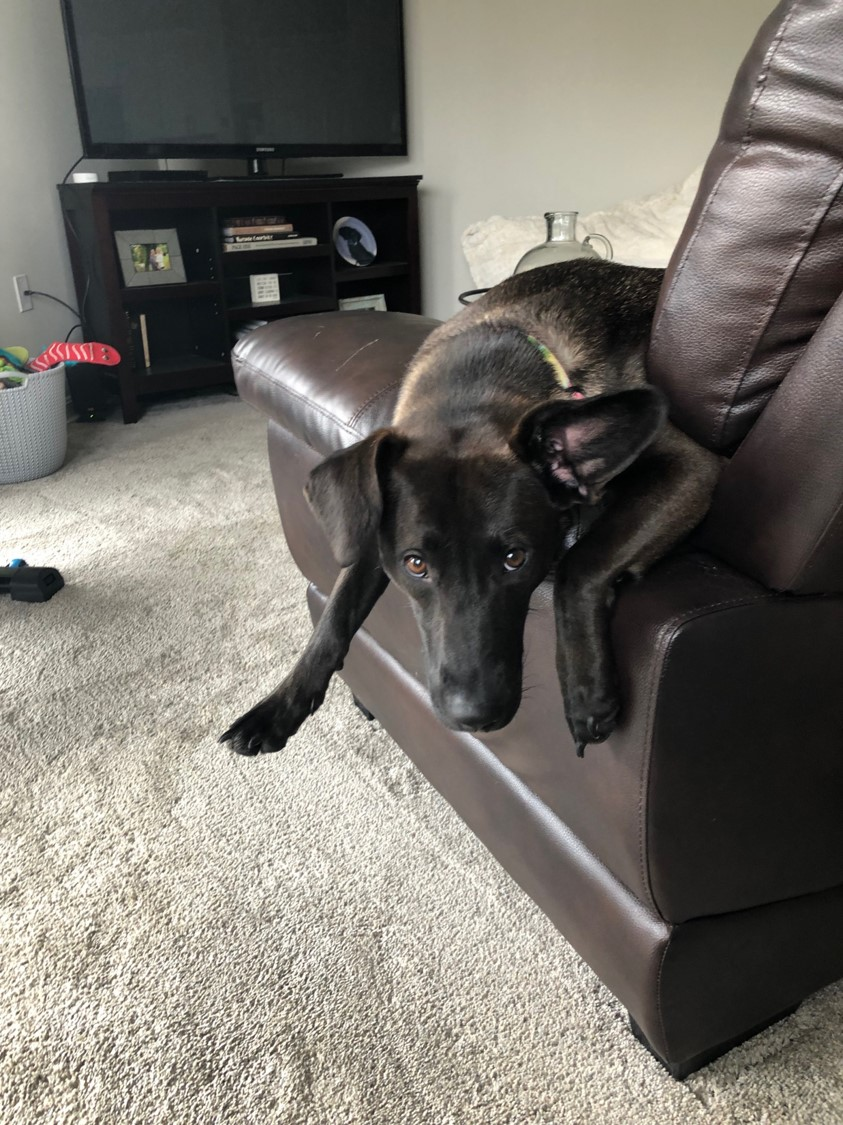

Sadie_5_0.jpg


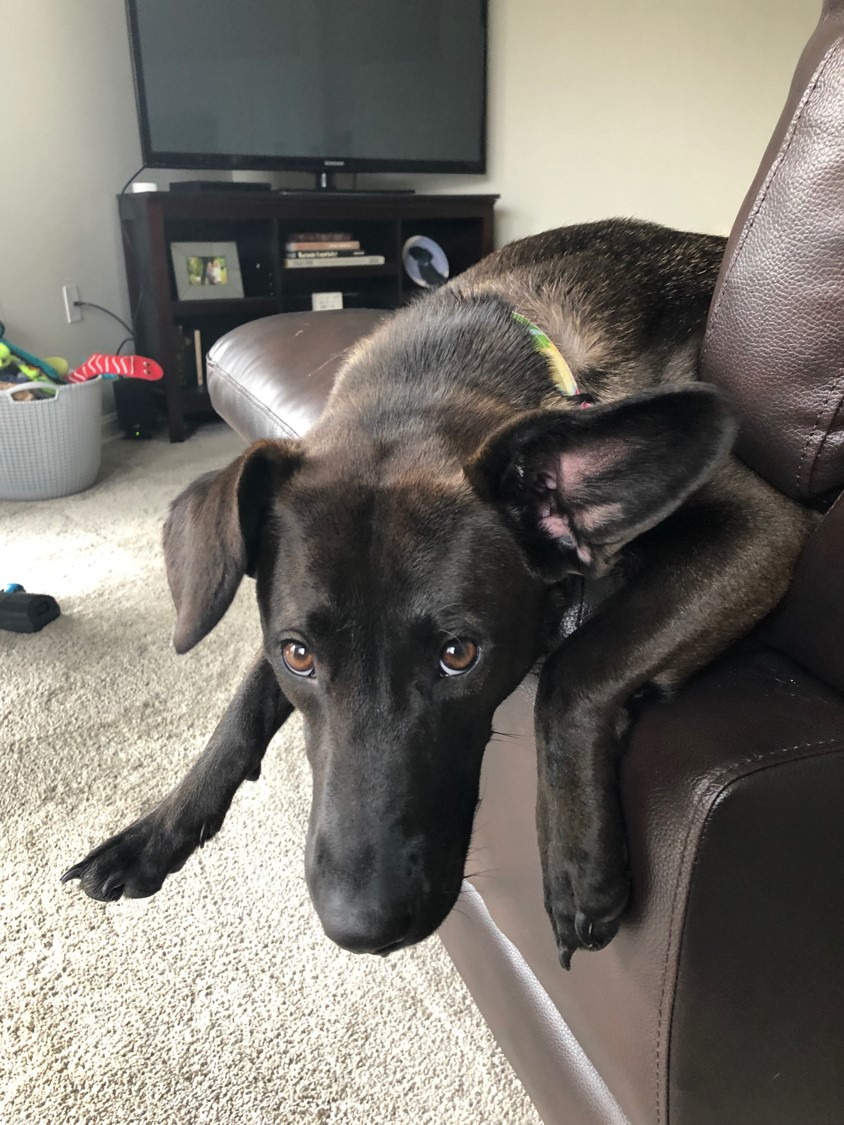

Sadie_6_0.jpg


In [74]:
for pic in sadie_images:
    display(Image2(pic, width = 150))
    print(pic)

We can see these are basically the same picture, but from a slightly different closeness. What I'd expect to see is smaller distance as compared to that of the Grumpy Cat compared to Goose. Additionally, I'd think that Sadie_3 is very similar to Sadie_5. 

I want to do the same thing for a new set of images of Goose. 

In [75]:
# change working directory
os.chdir(working_path+'/Images/Sample_Goose2')

# get list of images (.jpg only)
goose2_images = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]

# initialize
goose2_labels = []
goose2_dupe = []
goose2_idx_to_labels = []
goose2_label_to_idx = {}

# iterate
for fn in goose2_images:
    if not fn in goose2_label_to_idx:
        goose2_label_to_idx[fn] = len(goose2_idx_to_labels)
        goose2_idx_to_labels.append(fn)
    goose2_labels.append(goose2_label_to_idx[fn])
    goose2_dupe.append(int(fn.replace('.jpg','').rsplit('_', 2)[2]))
len(goose2_idx_to_labels)

print('')
print('Number of images: ')
print(len(goose2_images))
print('')
print('Sample images used: ')
print([i for i in goose2_idx_to_labels])
print('')


Number of images: 
5

Sample images used: 
['Goose2_1_0.jpg', 'Goose2_2_0.jpg', 'Goose2_3_0.jpg', 'Goose2_4_0.jpg', 'Goose2_5_0.jpg']



Let's see the pictures of Goose. 

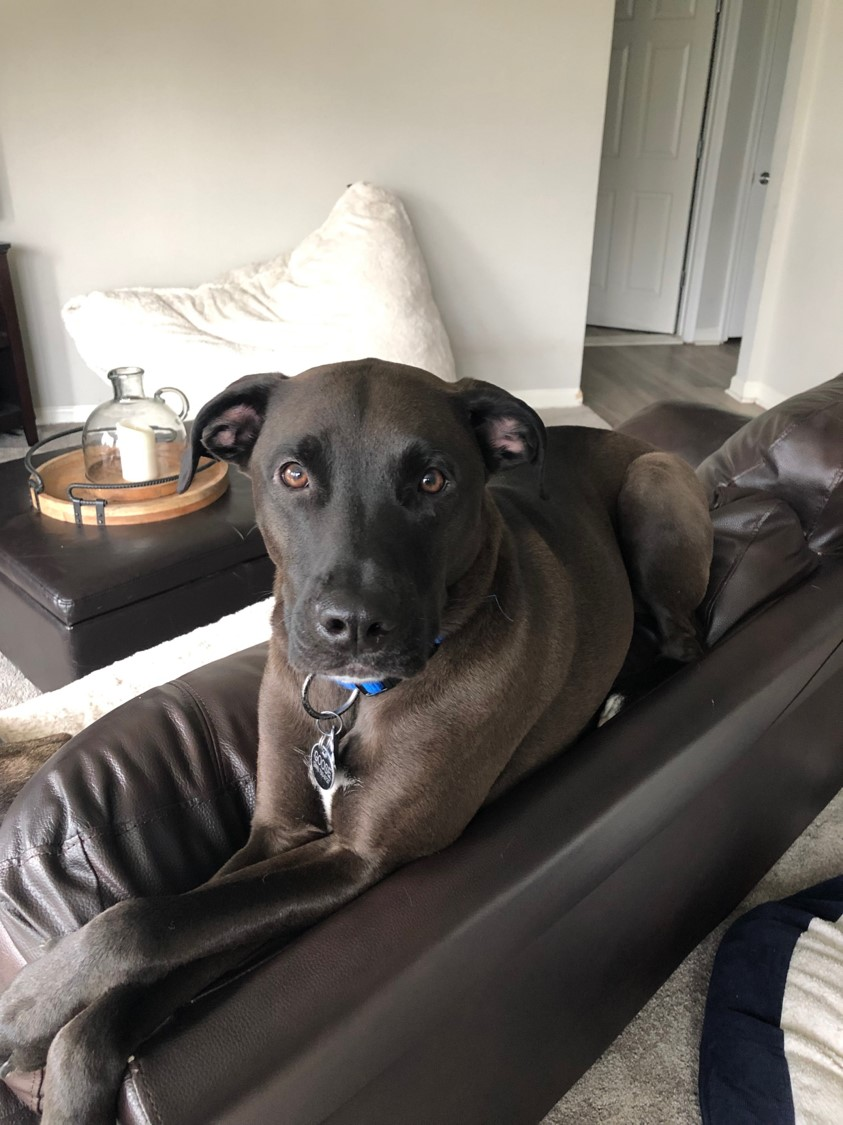

Goose2_1_0.jpg


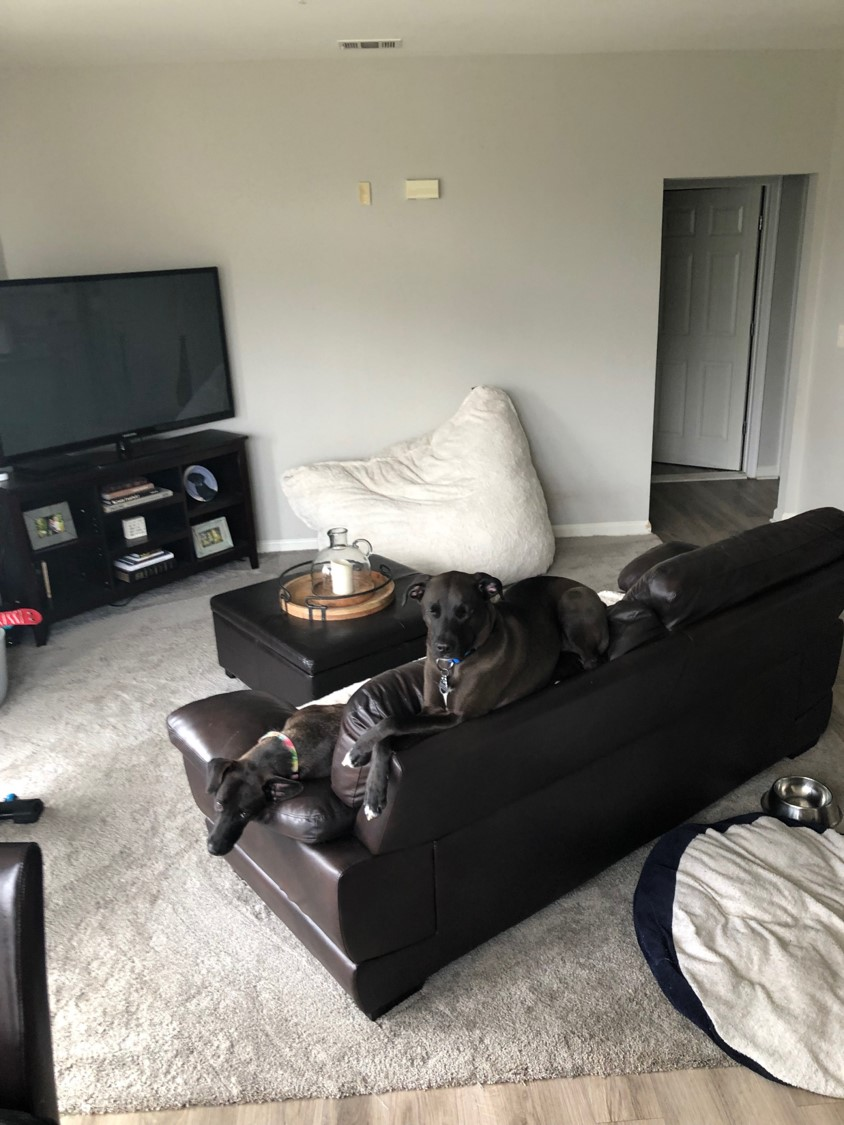

Goose2_2_0.jpg


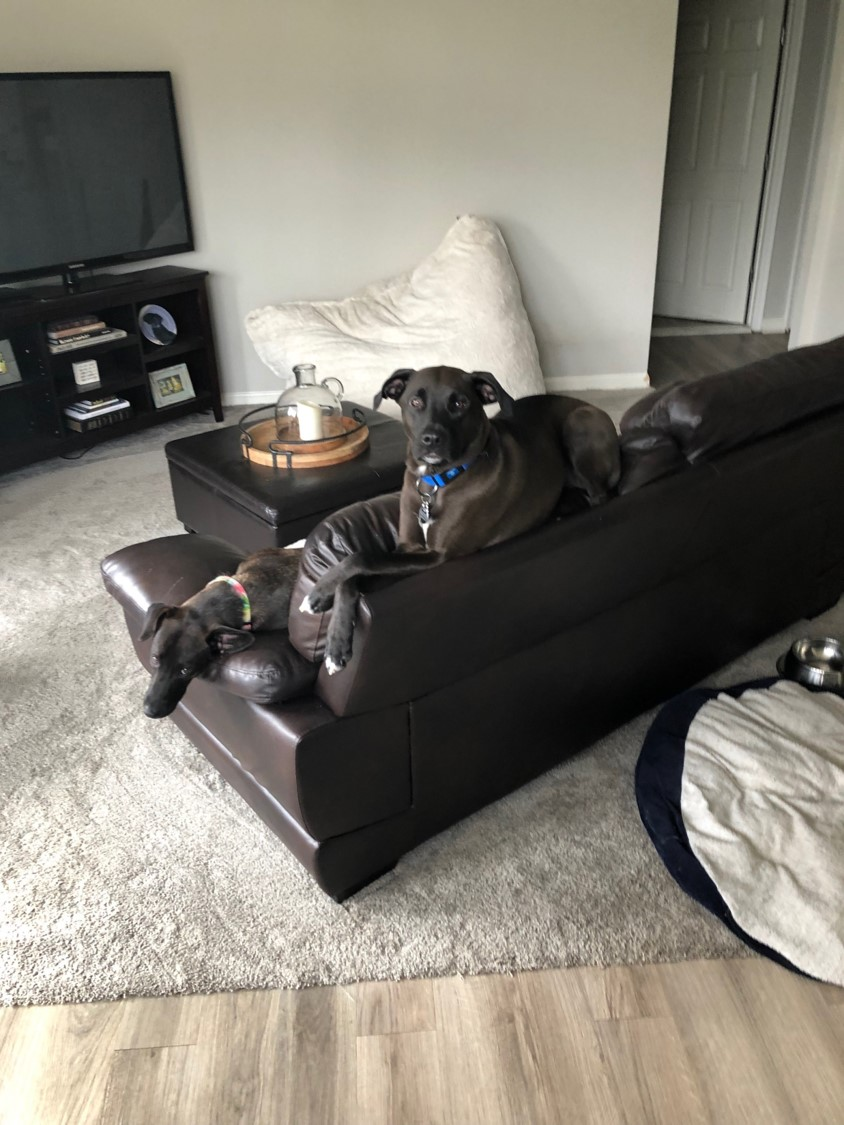

Goose2_3_0.jpg


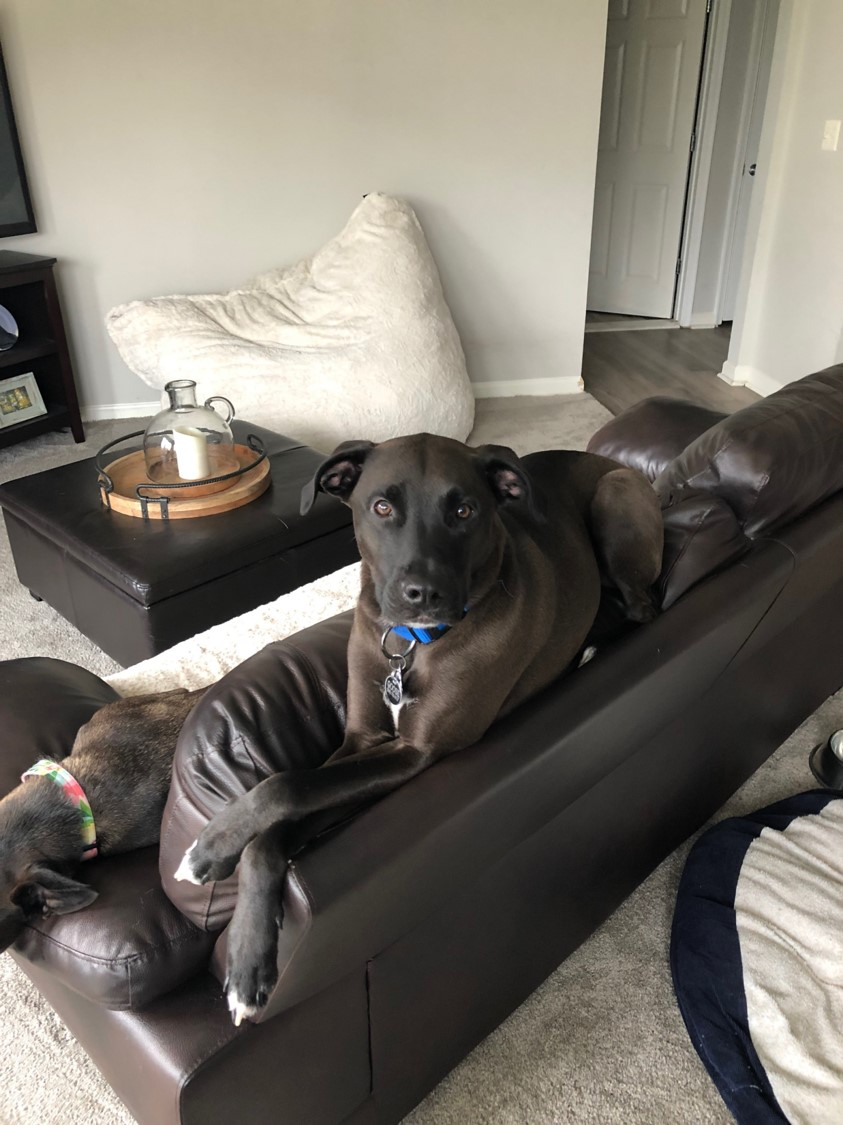

Goose2_4_0.jpg


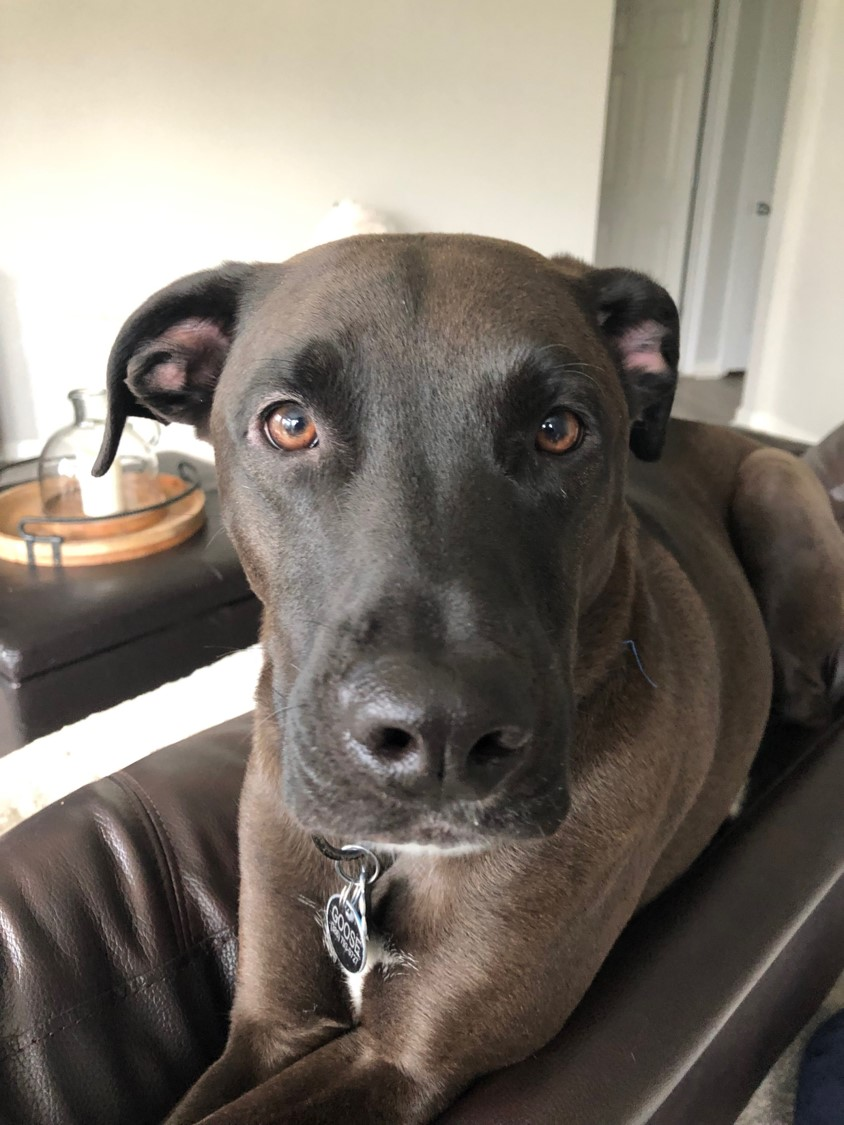

Goose2_5_0.jpg


In [79]:
for pic in goose2_images:
    display(Image2(pic, width = 150))
    print(pic)

Similarly for the series of Sadie, I'd expect Goos2_1 and Goose2_5 to have close distance values. 

Now, I need to normalize the images of Sadie

In [82]:
for i in range(0,len(sadie_images)): 
    os.chdir(working_path+'/Images/Sample_Sadie')
    image_name = sadie_images[i]
    temp_load = Image.open(image_name,'r')
    temp_load = temp_load.resize( (299,299), Image.ANTIALIAS )
    temp_load = temp_load.convert('L') # converts to monochrome
    temp_load = temp_load.convert('1') # converts to black and white
    os.chdir(working_path+'/Images/Sample_Sadie/Norm')
    temp_load.save(image_name, temp_load.format)
    temp_load.close()
    
os.chdir(working_path+'/Images/Sample_Sadie/Norm')
         
sadie_images_rs = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]
         
org_img_count = len(sadie_images)
rs_img_count = len(sadie_images_rs)

print('\n Original Images: ' + str(org_img_count) + '\n Resized Images: ' + str(rs_img_count))


 Original Images: 6
 Resized Images: 6


Similarly, I need to do this for Goose2. 

In [84]:
for i in range(0,len(goose2_images)): 
    os.chdir(working_path+'/Images/Sample_Goose2')
    image_name = goose2_images[i]
    temp_load = Image.open(image_name,'r')
    temp_load = temp_load.resize( (299,299), Image.ANTIALIAS )
    temp_load = temp_load.convert('L') # converts to monochrome
    temp_load = temp_load.convert('1') # converts to black and white
    os.chdir(working_path+'/Images/Sample_Goose2/Norm')
    temp_load.save(image_name, temp_load.format)
    temp_load.close()
    
os.chdir(working_path+'/Images/Sample_Goose2/Norm')
         
goose2_images_rs = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]
         
org_img_count = len(goose2_images)
rs_img_count = len(goose2_images_rs)

print('\n Original Images: ' + str(org_img_count) + '\n Resized Images: ' + str(rs_img_count))


 Original Images: 5
 Resized Images: 5


I'm going to skip displaying the output of the normalizing. I've already shown what that looks like and I quickly looked at the results in the /norm folder. 

I'm now going to run the model output and distance matrix of Sadie. I'm combining the steps into one code section and removing the display of the shape.

In [142]:
os.chdir(working_path+'/Images/Sample_Sadie/Norm')

use_images_sadie = [image.load_img(c, target_size=(299,299))
         for c in sadie_images]

use_tensor_sadie = np.array([image.img_to_array(img) for img in use_images_sadie])

model_output_sadie = model.predict(use_tensor_sadie, batch_size=32, verbose=1)

df_sadie = pd.DataFrame(model_output_sadie, index = sadie_images)

dist_mat_sadie = pd.DataFrame(distance_matrix(df_sadie.values,df_sadie.values),index=df_sadie.index,columns=df_sadie.index)

dist_mat_sadie

6/6 [==============================] - 0s 77ms/step


Sadie_1_0.jpg  Sadie_2_0.jpg  Sadie_3_0.jpg  Sadie_4_0.jpg  \
Sadie_1_0.jpg       0.000000      45.021889      50.173439      50.539696   
Sadie_2_0.jpg      45.021889       0.000000      29.950462      34.238880   
Sadie_3_0.jpg      50.173439      29.950462       0.000000      35.423908   
Sadie_4_0.jpg      50.539696      34.238880      35.423908       0.000000   
Sadie_5_0.jpg      54.318027      40.193554      33.695541      32.639244   
Sadie_6_0.jpg      61.472942      57.034325      49.109943      58.668221   

               Sadie_5_0.jpg  Sadie_6_0.jpg  
Sadie_1_0.jpg      54.318027      61.472942  
Sadie_2_0.jpg      40.193554      57.034325  
Sadie_3_0.jpg      33.695541      49.109943  
Sadie_4_0.jpg      32.639244      58.668221  
Sadie_5_0.jpg       0.000000      49.546753  
Sadie_6_0.jpg      49.546753       0.000000

These results show what I'd expect. Sadie_1 (most zoomed out) is most different from Sadie_6 (most zoomed in). Additionally, the middle images (Sadie_2 through Sadie_5) had similar distances. 

Run the same thing for Goose2. 

In [86]:
os.chdir(working_path+'/Images/Sample_Goose2/Norm')

use_images_goose2 = [image.load_img(c, target_size=(299,299))
         for c in goose2_images]

use_tensor_goose2 = np.array([image.img_to_array(img) for img in use_images_goose2])

model_output_goose2 = model.predict(use_tensor_goose2, batch_size=32, verbose=1)

df_goose2 = pd.DataFrame(model_output_goose2, index = goose2_images)

dist_mat_goose2 = pd.DataFrame(distance_matrix(df_goose2.values,df_goose2.values),index=df_goose2.index,columns=df_goose2.index)

dist_mat_goose2

5/5 [==============================] - 1s 233ms/step


Goose2_1_0.jpg  Goose2_2_0.jpg  Goose2_3_0.jpg  \
Goose2_1_0.jpg        0.000000       68.003983       62.146450   
Goose2_2_0.jpg       68.003983        0.000000       33.157429   
Goose2_3_0.jpg       62.146450       33.157429        0.000000   
Goose2_4_0.jpg       48.045738       66.090828       63.425610   
Goose2_5_0.jpg       48.986446       61.276917       59.356472   

                Goose2_4_0.jpg  Goose2_5_0.jpg  
Goose2_1_0.jpg       48.045738       48.986446  
Goose2_2_0.jpg       66.090828       61.276917  
Goose2_3_0.jpg       63.425610       59.356472  
Goose2_4_0.jpg        0.000000       52.472389  
Goose2_5_0.jpg       52.472389        0.000000

Looking at the results, it makes sense that Goose2_2 and Goose2_3 are the most similar, given the composition of the pictures. 

<a name='Enhancements'></a>
# Enhancements
* Transform the resulting distance matrix to be a list of the closest neighbor (not including itself)
* Run technique against a much larger data set of vehicles that were used in the previous project

These are the steps to grab the smallest distance across all other files.

In [150]:
# create a temp dataframe
stg_sadie = dist_mat_sadie

# add a column for file name equal to the index, which enables the melt
stg_sadie['File1']=stg_sadie.index

# grab column names
stg_cols = dist_mat_sadie.columns

# complete the melt
stg1 = pd.melt(stg_sadie, id_vars='File1',value_vars=stg_cols[stg_cols != 'File1'])

# clean up column names
stg1.columns = ['File1','File2','Distance']

# remove rows where files are the same, which removes self duplicates
stg2 = stg1[stg1.File1 != stg1.File2]

fnl_sadie = stg2.groupby('File1')['Distance'].min()

fnl_sadie

File1
Sadie_1_0.jpg    45.021889
Sadie_2_0.jpg    29.950462
Sadie_3_0.jpg    29.950462
Sadie_4_0.jpg    32.639244
Sadie_5_0.jpg    32.639244
Sadie_6_0.jpg    49.109943
Name: Distance, dtype: float32

For pictures of vehicles used in the prior project, add them to another folder and standardize naming conventions. 

In [155]:
vehicle_path = 'd:/projects/python/TL_logos/Vehicles/'
os.chdir(vehicle_path)

vehicle_list = [n for n in os.listdir() if n.upper().endswith('.JPG')]

for i in range(0,len(vehicle_list)):
    new_name = working_path + 'Images/Sample_Vehicles/' + 'Vehicle_' + str(i) + '_0.JPG'
    old_name = vehicle_path + vehicle_list[i]
    os.rename(old_name, new_name)

With those, I chose 30 images to duplicate. For these files, I changed the naming convention to Vehicle_D#_1 to indicate it is a duplicate.

Read in the new data set. 

In [180]:
# change working directory
os.chdir(working_path+'/Images/Sample_Vehicles')

# get list of images (.jpg only)
vehicles_images = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]

# initialize
vehicles_labels = []
vehicles_dupe = []
vehicles_idx_to_labels = []
vehicles_label_to_idx = {}

# iterate
for fn in vehicles_images:
    if not fn in vehicles_label_to_idx:
        vehicles_label_to_idx[fn] = len(vehicles_idx_to_labels)
        vehicles_idx_to_labels.append(fn)
    vehicles_labels.append(vehicles_label_to_idx[fn])
    vehicles_dupe.append(int(fn.replace('.jpg','').replace('.JPG','').rsplit('_', 2)[2]))
len(vehicles_idx_to_labels)

print('')
print('Number of images: ')
print(len(vehicles_images))



Number of images: 
524


See the images that I entered into the folder as duplicates. 

In [197]:
dupes_in_folder = 0 

for i in vehicles_images: 
    if i.endswith('1.JPG'):
        print(i)
        dupes_in_folder += 1

print('\n Duplicates in the folder: ' + str(dupes_in_folder))
print('\n We should see ' + str(dupes_in_folder * 2) + ' duplicates in the resulting list. ')

Vehicle_D0_1.JPG
Vehicle_D10_1.JPG
Vehicle_D13_1.JPG
Vehicle_D190_1.JPG
Vehicle_D191_1.JPG
Vehicle_D192_1.JPG
Vehicle_D193_1.JPG
Vehicle_D194_1.JPG
Vehicle_D195_1.JPG
Vehicle_D196_1.JPG
Vehicle_D197_1.JPG
Vehicle_D199_1.JPG
Vehicle_D1_1.JPG
Vehicle_D200_1.JPG
Vehicle_D383_1.JPG
Vehicle_D384_1.JPG
Vehicle_D385_1.JPG
Vehicle_D386_1.JPG
Vehicle_D387_1.JPG
Vehicle_D389_1.JPG
Vehicle_D390_1.JPG
Vehicle_D391_1.JPG
Vehicle_D392_1.JPG
Vehicle_D393_1.JPG
Vehicle_D4_1.JPG
Vehicle_D5_1.JPG
Vehicle_D6_1.JPG
Vehicle_D8_1.JPG
Vehicle_D9_1.JPG

 Duplicates in the folder: 29

 We should see 58 duplicates in the resulting list. 


Normalize the vehicle images.

In [181]:
for i in range(0,len(vehicles_images)): 
    os.chdir(working_path+'/Images/Sample_Vehicles')
    image_name = vehicles_images[i]
    temp_load = Image.open(image_name,'r')
    temp_load = temp_load.resize( (299,299), Image.ANTIALIAS )
    temp_load = temp_load.convert('L') # converts to monochrome
    temp_load = temp_load.convert('1') # converts to black and white
    os.chdir(working_path+'/Images/Sample_Vehicles/Norm')
    temp_load.save(image_name, temp_load.format)
    temp_load.close()
    
os.chdir(working_path+'/Images/Sample_Vehicles/Norm')
         
vehicles_images_rs = [fn for fn in os.listdir() if fn.upper().endswith('.JPG')]
         
org_img_count = len(vehicles_images)
rs_img_count = len(vehicles_images_rs)

print('\n Original Images: ' + str(org_img_count) + '\n Resized Images: ' + str(rs_img_count))


 Original Images: 524
 Resized Images: 524


Run the model for each image. 

In [183]:
os.chdir(working_path+'/Images/Sample_Vehicles/Norm')

use_images_vehicles = [image.load_img(c, target_size=(299,299))
         for c in vehicles_images]

use_tensor_vehicles = np.array([image.img_to_array(img) for img in use_images_vehicles])

model_output_vehicles = model.predict(use_tensor_vehicles, batch_size=32, verbose=1)

df_vehicles = pd.DataFrame(model_output_vehicles, index = vehicles_images)

dist_mat_vehicles = pd.DataFrame(distance_matrix(df_vehicles.values,df_vehicles.values),index=df_vehicles.index,columns=df_vehicles.index)


524/524 [==============================] - 4s 8ms/step


Get the minimum distance per image. 

In [186]:
# create a temp dataframe
stg_vehicles = dist_mat_vehicles

# add a column for file name equal to the index, which enables the melt
stg_vehicles['File1']=stg_vehicles.index

# grab column names
stg_cols = dist_mat_vehicles.columns

# complete the melt
stg1 = pd.melt(stg_vehicles, id_vars='File1',value_vars=stg_cols[stg_cols != 'File1'])

# clean up column names
stg1.columns = ['File1','File2','Distance']

# remove rows where files are the same, which removes self duplicates
stg2 = stg1[stg1.File1 != stg1.File2]

fnl_vehicles = stg2.groupby('File1')['Distance'].min()

fnl_vehicles

File1
Vehicle_0_0.JPG        0.000000
Vehicle_101_0.JPG     52.329605
Vehicle_102_0.JPG     67.058189
Vehicle_103_0.JPG     48.345741
Vehicle_104_0.JPG     51.581345
Vehicle_107_0.JPG     73.540382
Vehicle_108_0.JPG     35.261662
Vehicle_109_0.JPG     38.259716
Vehicle_10_0.JPG       0.000000
Vehicle_110_0.JPG     33.861008
Vehicle_112_0.JPG     41.190605
Vehicle_113_0.JPG     33.526703
Vehicle_114_0.JPG     30.081617
Vehicle_115_0.JPG     33.299950
Vehicle_117_0.JPG     35.664158
Vehicle_118_0.JPG     44.543621
Vehicle_119_0.JPG     34.344978
Vehicle_120_0.JPG     34.076992
Vehicle_121_0.JPG     38.255520
Vehicle_122_0.JPG     39.387169
Vehicle_123_0.JPG     27.957991
Vehicle_124_0.JPG     43.084984
Vehicle_125_0.JPG     45.165390
Vehicle_126_0.JPG     33.953304
Vehicle_127_0.JPG     42.620045
Vehicle_128_0.JPG     33.161491
Vehicle_129_0.JPG     33.216381
Vehicle_12_0.JPG      46.759911
Vehicle_130_0.JPG     71.749336
Vehicle_131_0.JPG     45.131649
                        ...    
Ve

<a name='Results'></a>
# Results
* Identified duplicate images
* Show near-duplicate images

See the duplicates. 

In [208]:
vehicle_dupes = fnl_vehicles[fnl_vehicles<1]

In [209]:
len(vehicle_dupes)

58

The 58 length shows that it correctly identified the 29 duplicates and 29 original images that had a duplicate made. 

In [262]:
vehicle_dupes

File1
Vehicle_0_0.JPG       0.000000
Vehicle_10_0.JPG      0.000000
Vehicle_13_0.JPG      0.000000
Vehicle_190_0.JPG     0.000000
Vehicle_191_0.JPG     0.000000
Vehicle_192_0.JPG     0.000000
Vehicle_193_0.JPG     0.000000
Vehicle_194_0.JPG     0.000000
Vehicle_195_0.JPG     0.000000
Vehicle_196_0.JPG     0.000000
Vehicle_197_0.JPG     0.000000
Vehicle_199_0.JPG     0.000000
Vehicle_1_0.JPG       0.000000
Vehicle_200_0.JPG     0.000000
Vehicle_383_0.JPG     0.000000
Vehicle_384_0.JPG     0.000000
Vehicle_385_0.JPG     0.000000
Vehicle_386_0.JPG     0.003754
Vehicle_387_0.JPG     0.003139
Vehicle_389_0.JPG     0.002368
Vehicle_390_0.JPG     0.002552
Vehicle_391_0.JPG     0.003242
Vehicle_392_0.JPG     0.002737
Vehicle_393_0.JPG     0.002875
Vehicle_4_0.JPG       0.002283
Vehicle_5_0.JPG       0.002194
Vehicle_6_0.JPG       0.002132
Vehicle_8_0.JPG       0.003076
Vehicle_9_0.JPG       0.002574
Vehicle_D0_1.JPG      0.000000
Vehicle_D10_1.JPG     0.000000
Vehicle_D13_1.JPG     0.000000
Ve

The interesting thing about this technique isn't finding perfect duplicates, which could be accomplished other ways. If we select distances greater than 0 and less than a threshold, we can find similar images. 

In [263]:
vehicles_similar = fnl_vehicles[fnl_vehicles<26] # 26 was derived based on results examination

In [264]:
vehicles_similar_not_same = vehicles_similar[vehicles_similar>=1]

In [265]:
vehicles_similar_not_same

File1
Vehicle_302_0.JPG    24.751698
Vehicle_329_0.JPG    24.751698
Vehicle_338_0.JPG    25.986731
Vehicle_374_0.JPG    25.986731
Vehicle_396_0.JPG    25.059502
Name: Distance, dtype: float64

For the list of vehicle pictures that are similar, but not the same, get the file name that it most closely matches to. 

In [266]:
similar_df = pd.DataFrame(vehicles_similar_not_same)
joined_results = pd.merge(similar_df,stg2,how='left',on=['File1','Distance'])

Display the groupings of similar, but not exact duplicate, vehicles. 

In [267]:
joined_results

File1   Distance              File2
0  Vehicle_302_0.JPG  24.751698  Vehicle_329_0.JPG
1  Vehicle_329_0.JPG  24.751698  Vehicle_302_0.JPG
2  Vehicle_338_0.JPG  25.986731  Vehicle_374_0.JPG
3  Vehicle_374_0.JPG  25.986731  Vehicle_338_0.JPG
4  Vehicle_396_0.JPG  25.059502  Vehicle_302_0.JPG

Similar group 1


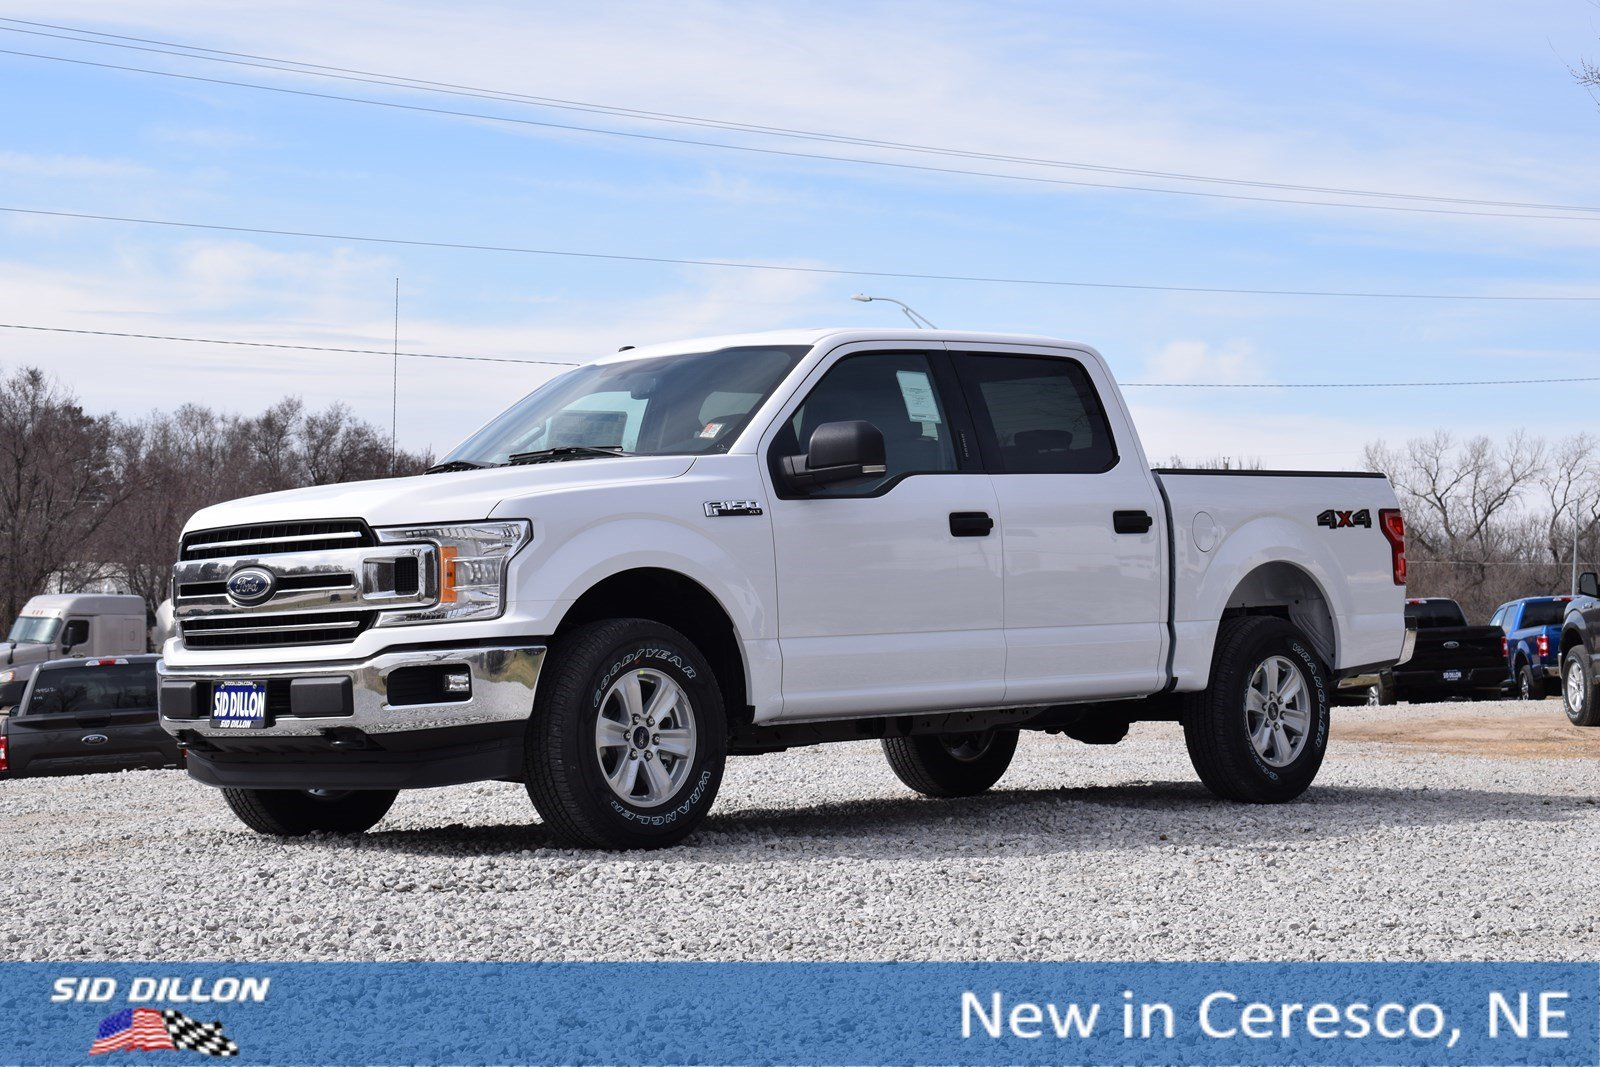

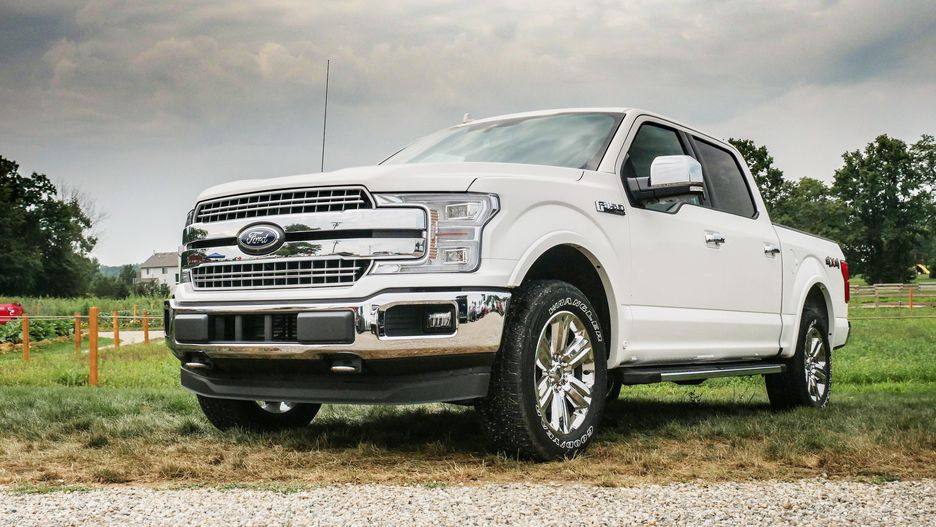

Vehicle_329_0.JPG


Similar group 2


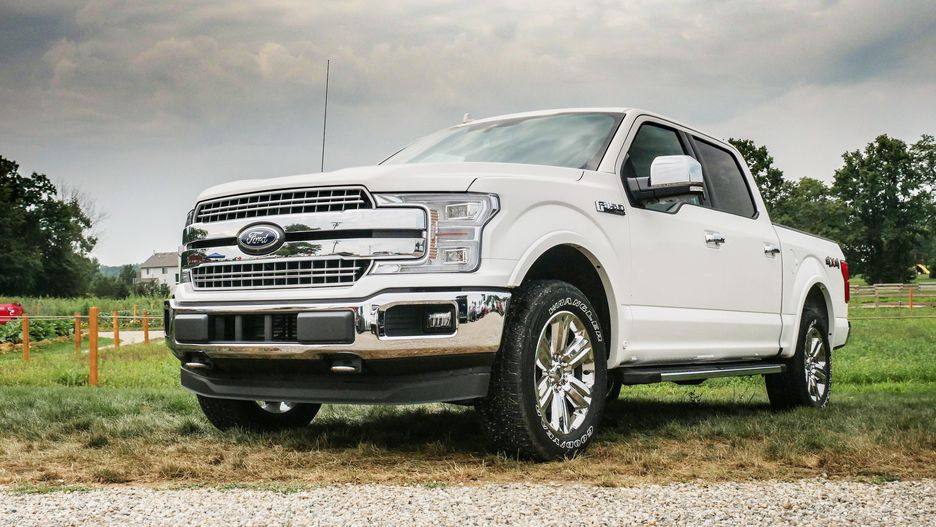

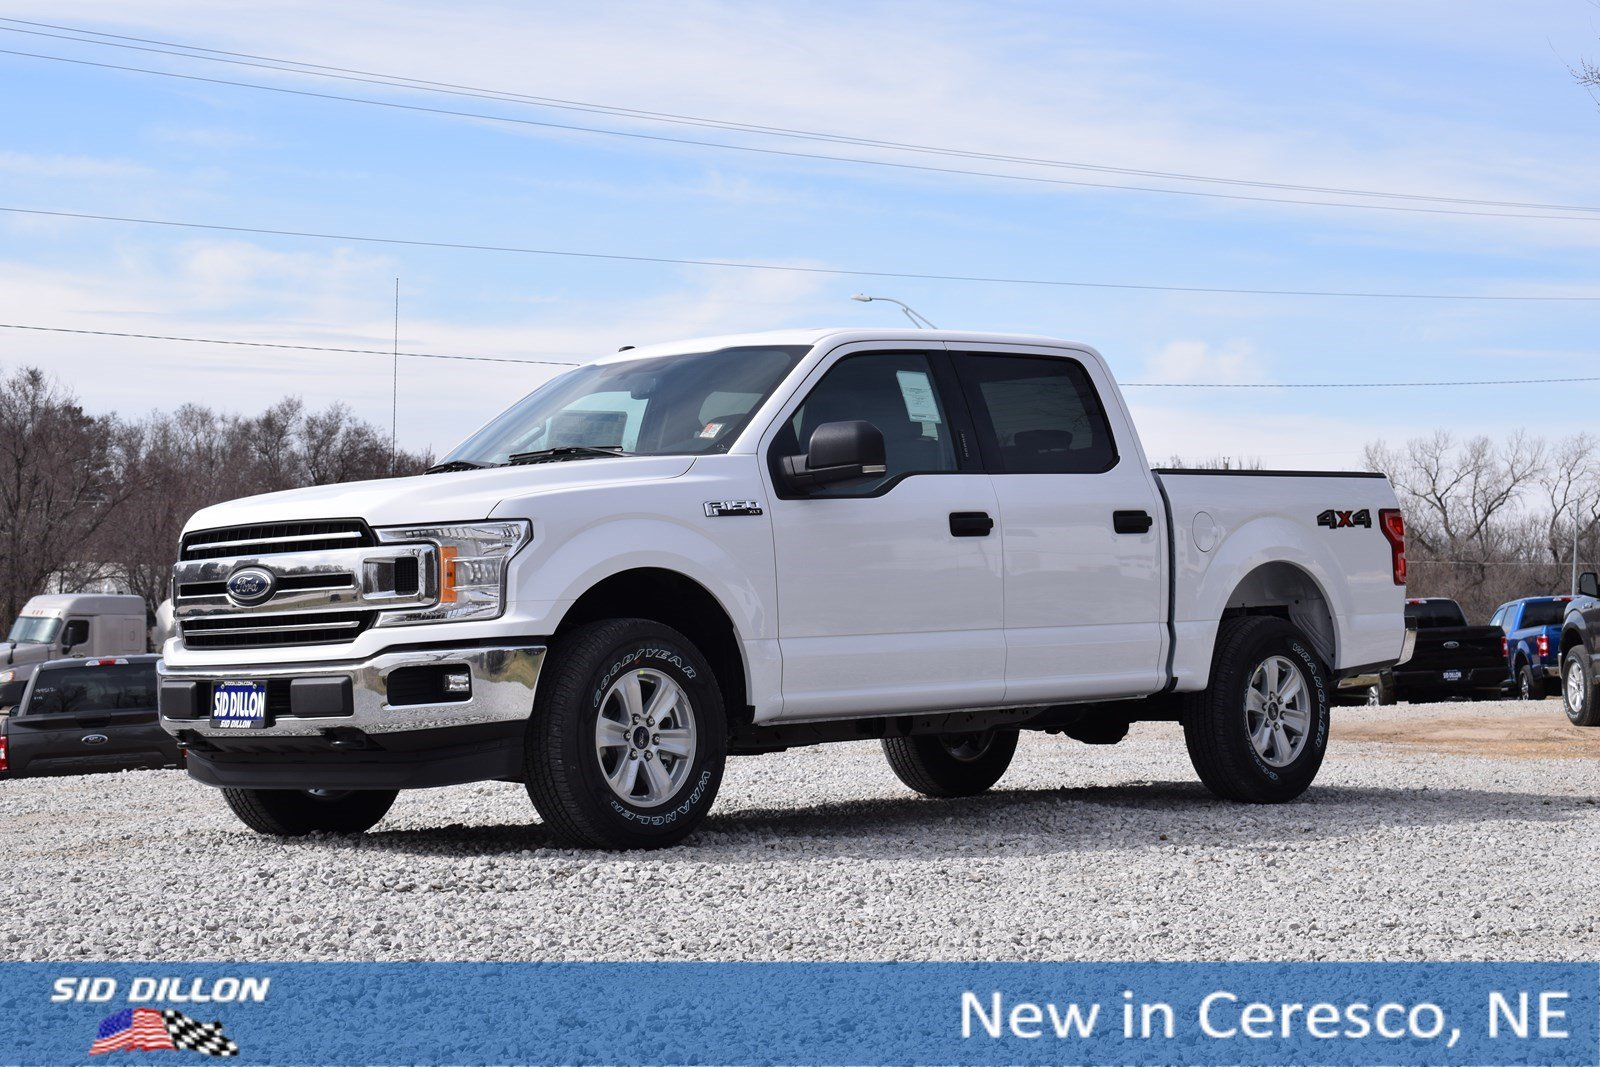

Vehicle_302_0.JPG


Similar group 3


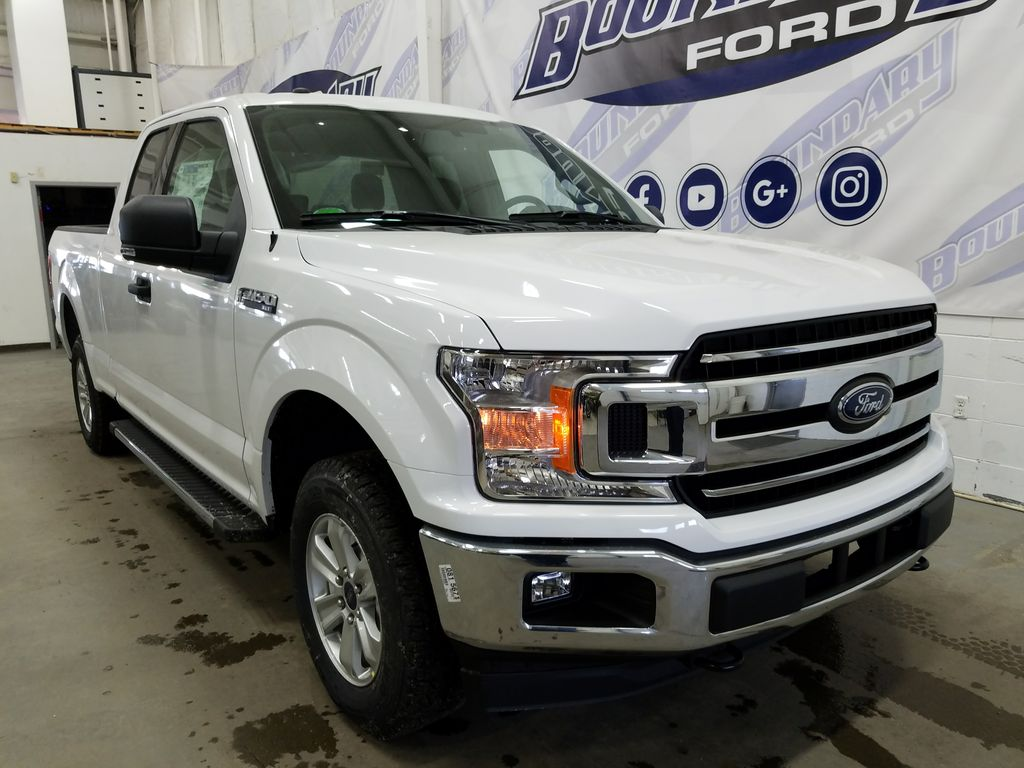

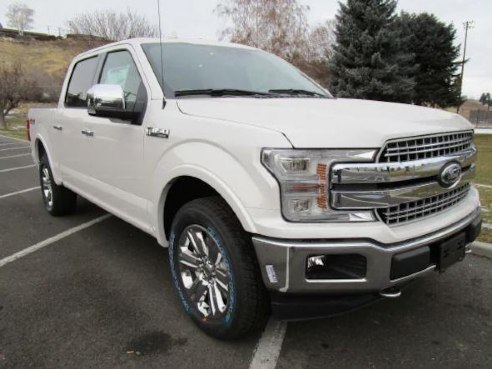

Vehicle_374_0.JPG


Similar group 4


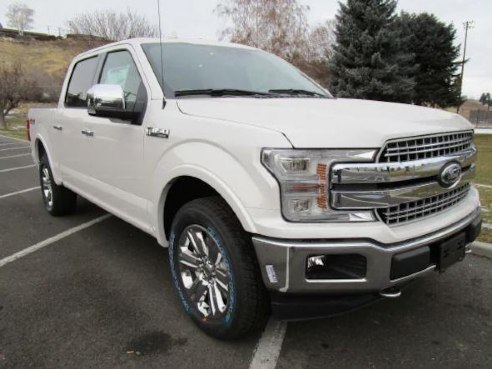

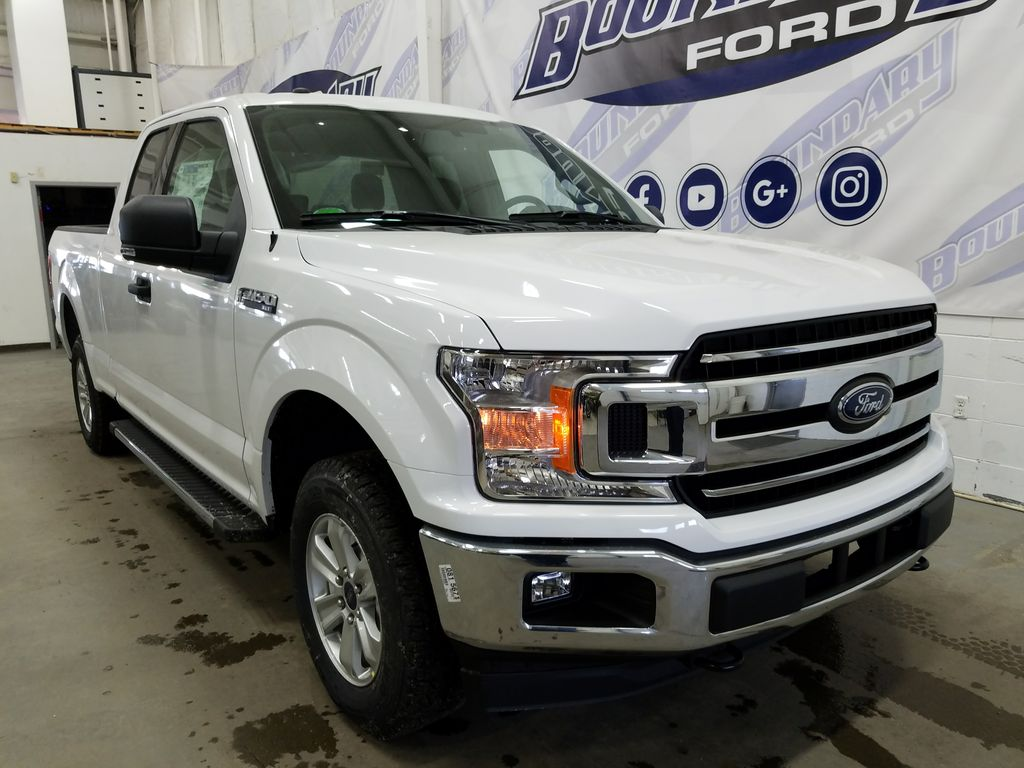

Vehicle_338_0.JPG


Similar group 5


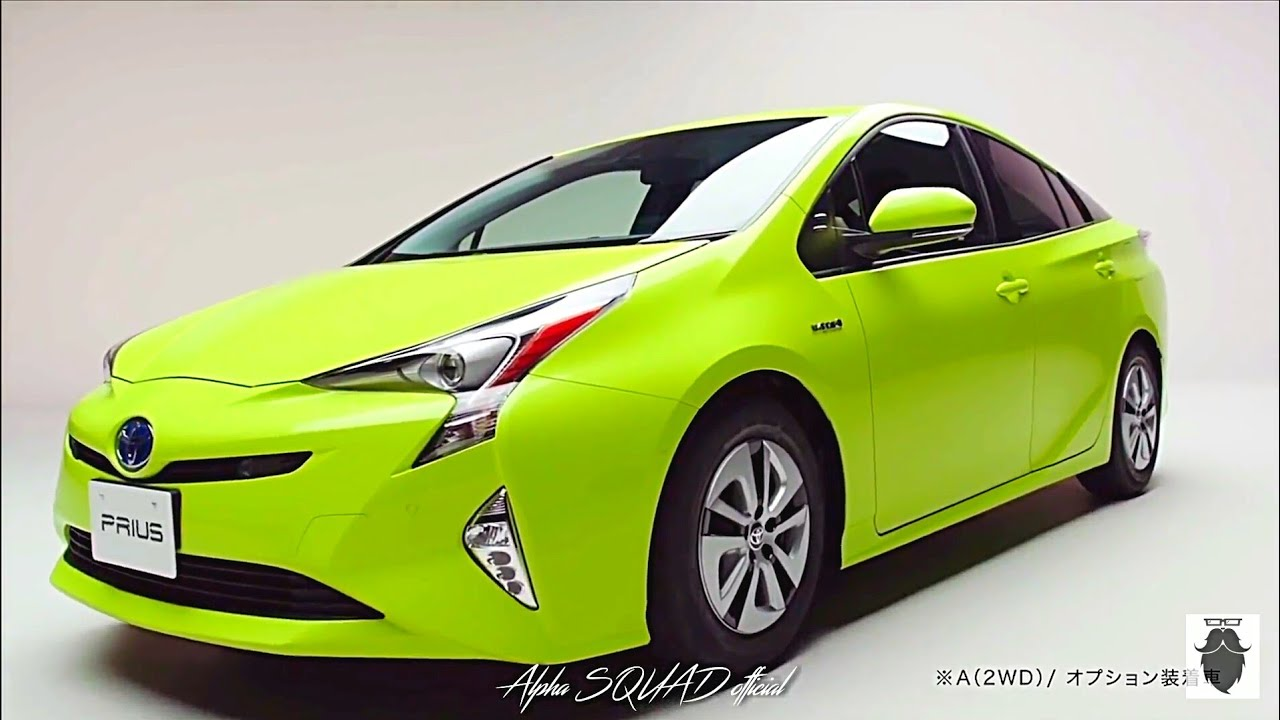

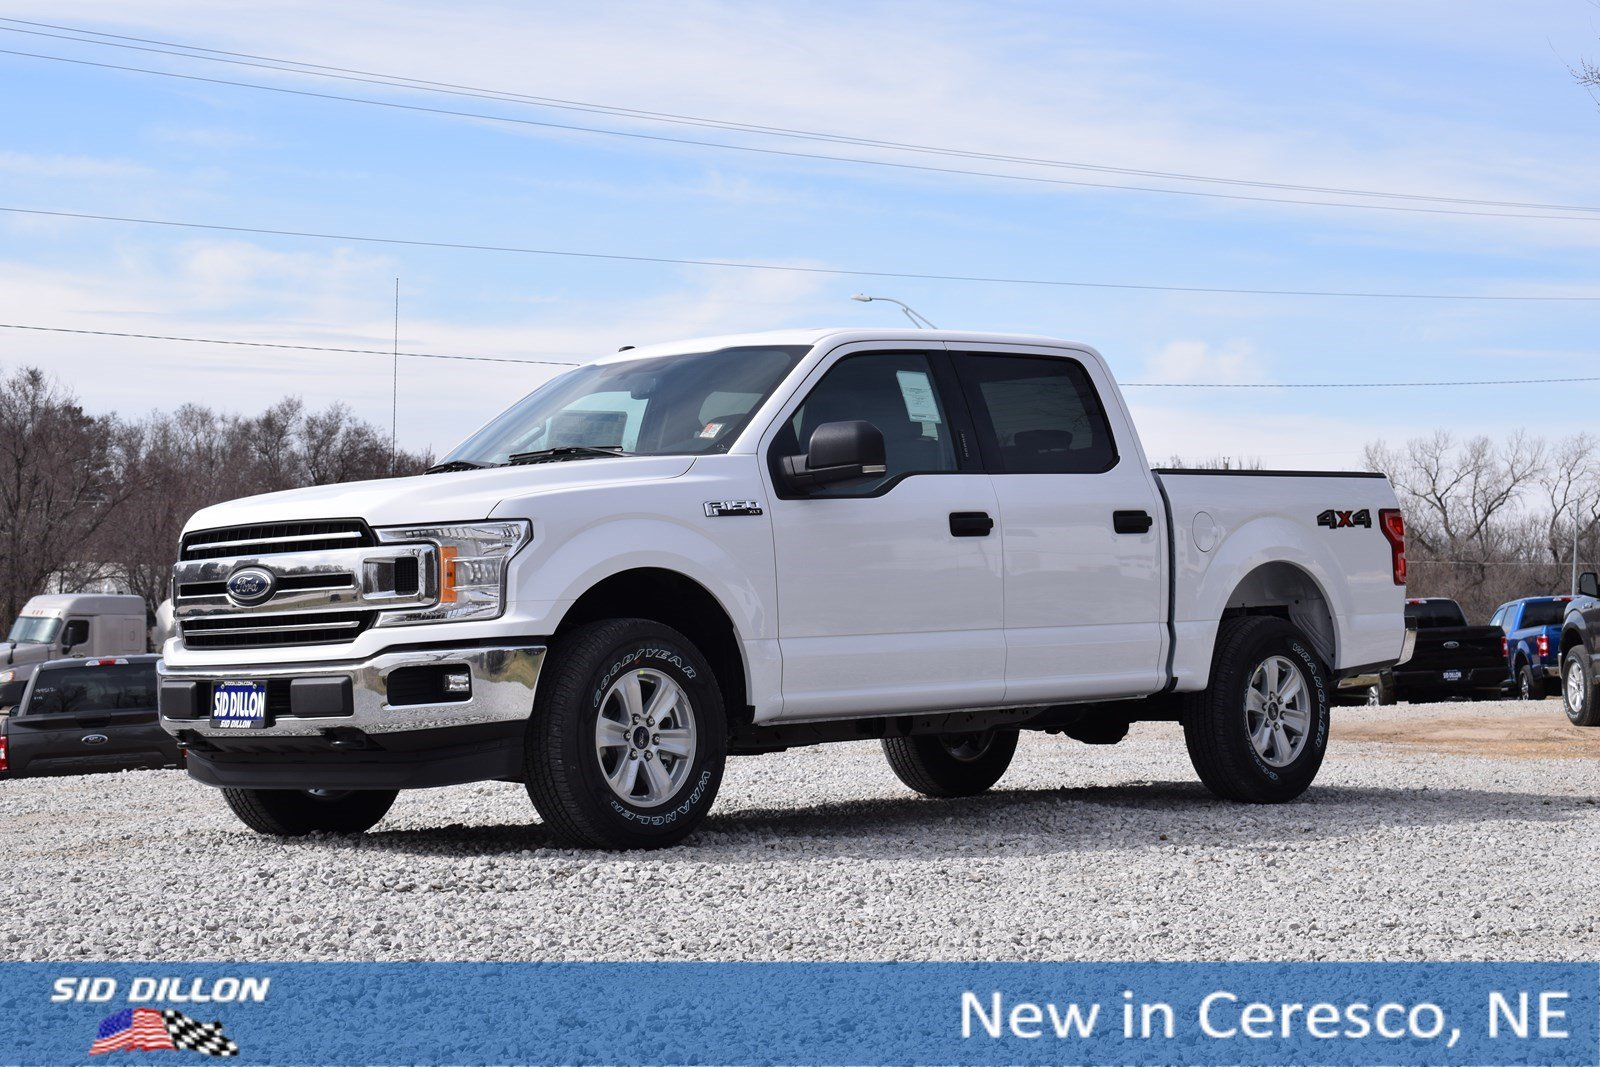

Vehicle_302_0.JPG




In [268]:
os.chdir(working_path+'/Images/Sample_Vehicles')

for i in range(0,len(joined_results)):
    print('Similar group ' + str(i+1))
    pic = joined_results.File1[i]
    display(Image2(pic, width = 150))
    pic = joined_results.File2[i]
    display(Image2(pic, width = 150))
    print(pic)
    print('\n')

We can see that using a low distance metric was successful in finding some similar images. Further review results also shows that background of the image impacts results. That is to say that humans focus on the foreground, while the models look at the entire image. 

If we had the training data, we would be able to set up a logistic regression to predict duplicate and near-duplicate images. At this time, I'm not interested in creating that training data :)